In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-radiography-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F576013%2F3324348%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240705%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240705T080209Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e01aa73b17b2a13e080dc5418fb0c1acd03b1d510c3e071483c698ee3de1df7aae5725eed4f0c6f1b283197494d3f052ae6bc51028f883f971d5f00f3db3c0b1c1c910b16f86c1e5141f2db79456b13793d03884f093a91cd71f3414900470cc17b4cdf6c78d67ca989095f033f382b6ee81688aef6317abd88204f437bd558e89d4edc4db92f5881a21b0aefa48862ccbbd47fc039eaf8f47cf5a377a1c3cbc703f9884b7455d87e18e5b37507989ce6d8a5c4a6a05dfe4a9ad89c9946ee5139dbaf79ad0d66d8d14351ed0b54d7f9c6bd501c5a8bf8a5ac91b4183d4ce226b7642ef64f582a43e9cb0c4dd265b34a2e35b6dfd24acf0c99b243f82008b060'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# funtion for load data :

In [ ]:
#Generating data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)


            if pathlib.Path(foldpath).suffix == '':
                if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                    continue

                else:
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        filepaths.append(ipath)
                        labels.append(fold)

            else:
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels



def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Splitting dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

# function for load classes

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''



    img_size = (224, 224)
    channels = 3 # either RGB or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)


    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

# function for showing the images

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    # calculate number of displayed samples
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()


In [ ]:
data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# Splitting data
train_df, valid_df, test_df = split_data(data_dir)

# Generators
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


# show some images in training set

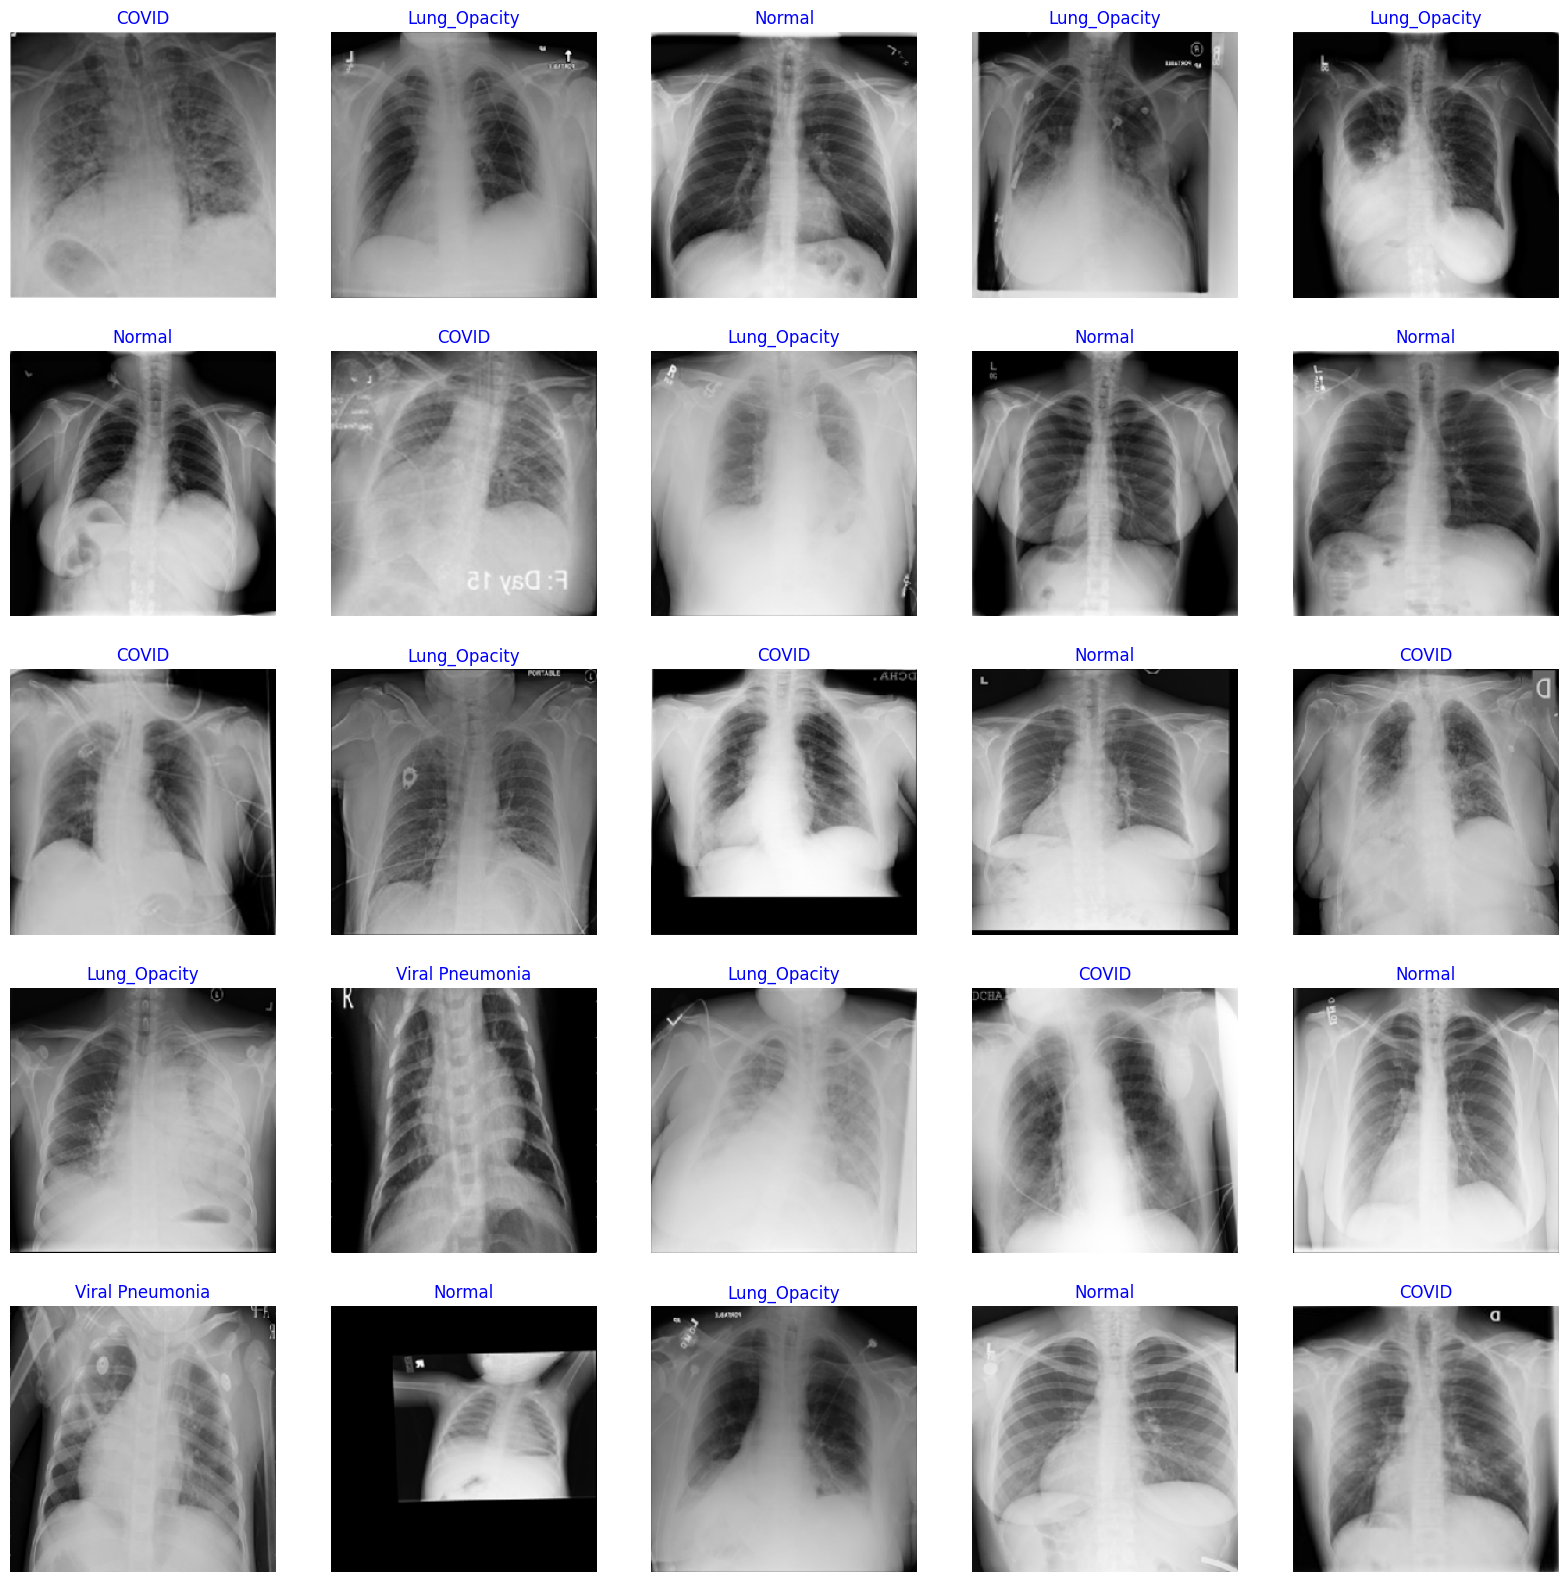

In [ ]:
show_images(train_gen)

# building the model:

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
base_model = EfficientNetB1(weights='imagenet', include_top=False,pooling='max')
x = base_model.output
x= Dense(128, activation='relu')(x)
x=Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model =Model(inputs=base_model.input, outputs=predictions)


optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 6,739,723 (25.71 MB)

 Trainable params: 6,677,668 (25.47 MB)

 Non-trainable params: 62,055 (242.41 KB)

# trian the model:

In [ ]:
history = model.fit(train_gen, epochs=25, validation_data=valid_gen)

Epoch 1/25


I0000 00:00:1720163246.704152      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 ━━━━━━━━━━━━━━━━━━━━ 427s 529ms/step - accuracy: 0.5684 - loss: 1.9891 - val_accuracy: 0.7524 - val_loss: 0.6557
Epoch 2/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.8575 - loss: 0.3930 - val_accuracy: 0.8998 - val_loss: 0.2749
Epoch 4/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.8900 - loss: 0.3203 - val_accuracy: 0.9168 - val_loss: 0.2349
Epoch 5/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.9048 - loss: 0.2664 - val_accuracy: 0.9197 - val_loss: 0.2197
Epoch 6/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.9139 - loss: 0.2407 - val_accuracy: 0.9272 - val_loss: 0.2091
Epoch 7/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.9277 - loss: 0.2052 - val_accuracy: 0.9329 - val_loss: 0.1955
Epoch 8/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.9325 - loss: 0.1849 - val_accuracy: 0.9371 - val_loss: 0.1843
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - accuracy: 0.9412 - loss: 0.1581 - val_accuracy:

# evaluating the test:

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_gen)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 764ms/step - accuracy: 0.9506 - loss: 0.1865
Test Loss: 0.1797747164964676
Test Accuracy: 0.9537080526351929


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

### CNN model performance metrics

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step


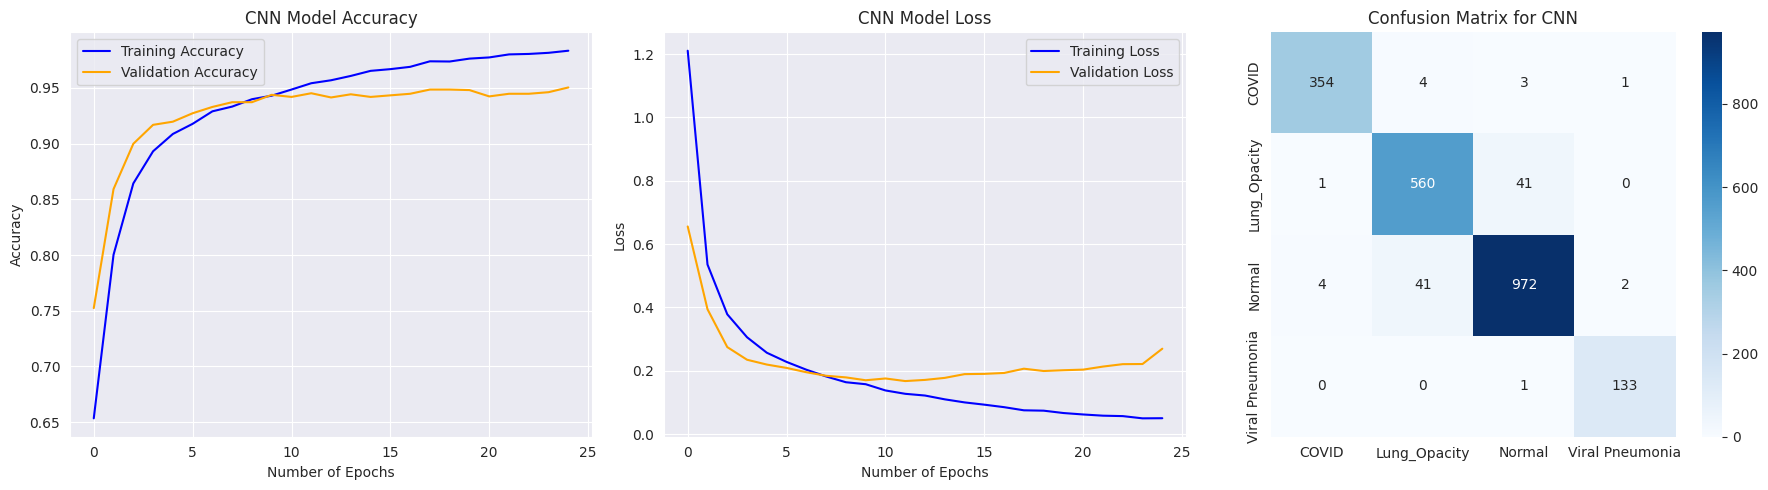

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure for the subplots
plt.figure(figsize=(18, 5))

# Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.legend()

# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix for CNN')

plt.tight_layout()
plt.show()